In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

stroke = pd.read_csv("/Users/angiean/ML group project/01_materials/stroke_data.csv")
stroke = stroke.drop(columns=['id'])
stroke = stroke[stroke['gender'] != 'Other']
df = stroke.copy()
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Make a chart for each feature showing how stroke and non-stroke groups differ.

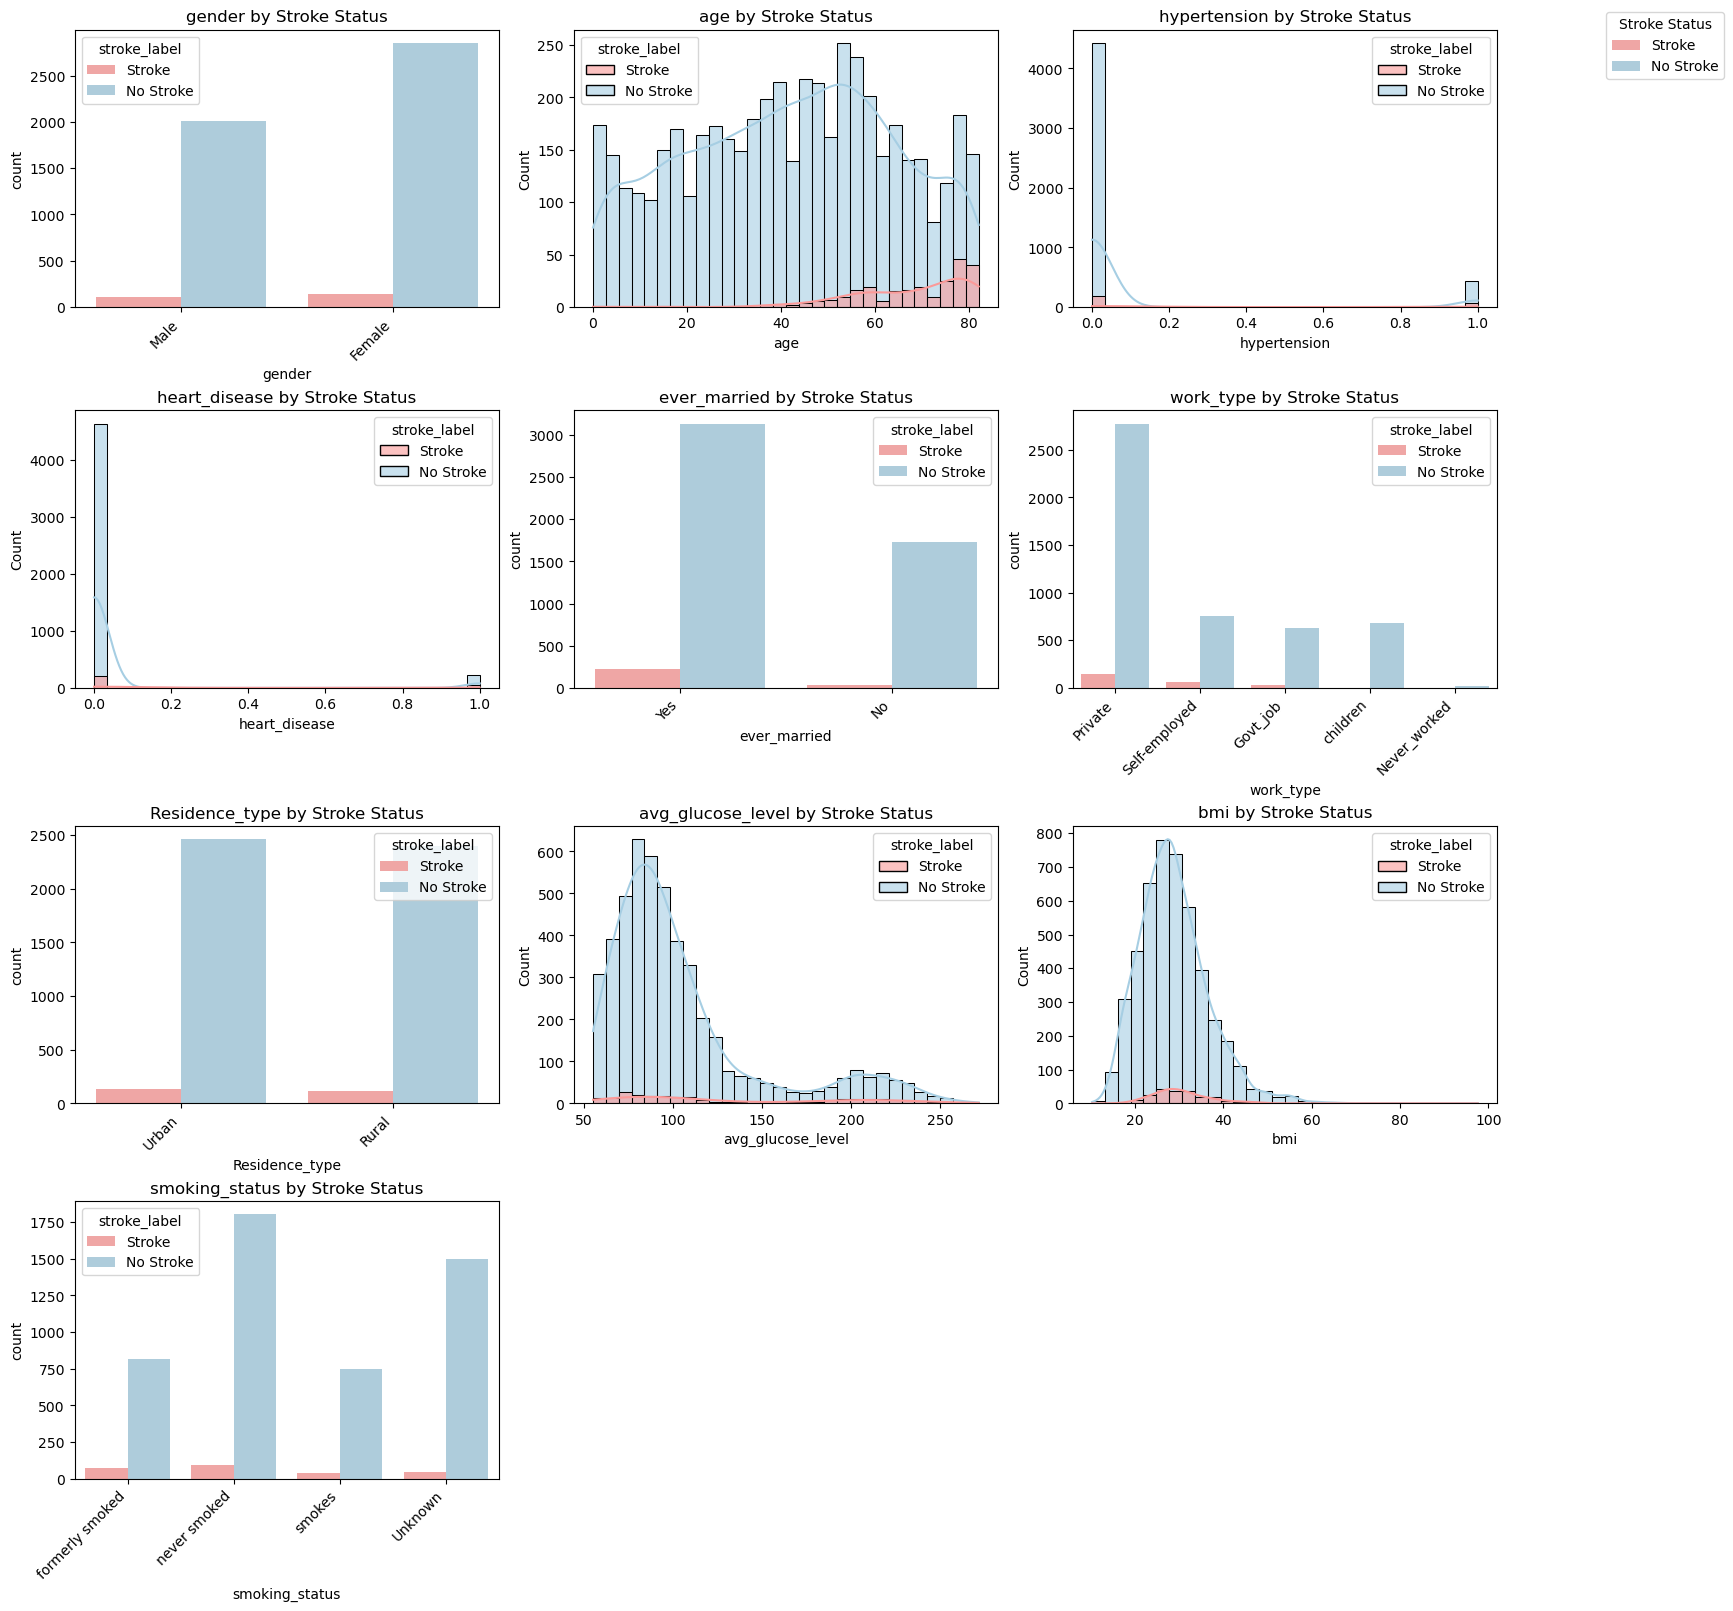

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

df = stroke.copy()
df['stroke_label'] = df['stroke'].map({0: 'No Stroke', 1: 'Stroke'})

custom_palette = {'No Stroke': '#A6CEE3', 'Stroke': '#FB9A99'}
features = [col for col in df.columns if col not in ['id', 'stroke', 'stroke_label']]

n_cols = 3
n_rows = int(np.ceil(len(features) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows), constrained_layout=True)
axes = axes.flatten()

for i, feature in enumerate(features):
    ax = axes[i]
    if pd.api.types.is_numeric_dtype(df[feature]):
        sns.histplot(data=df, x=feature, hue='stroke_label', kde=True, bins=30,
                     palette=custom_palette, alpha=0.6, multiple='layer', ax=ax)
    else:
        sns.countplot(data=df, x=feature, hue='stroke_label', palette=custom_palette, ax=ax)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_title(f'{feature} by Stroke Status')

# Remove any empty subplots if number of features < n_rows*n_cols
for j in range(i+1, n_rows*n_cols):
    fig.delaxes(axes[j])

# Create a single legend for the entire figure
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, title='Stroke Status', loc='upper right', bbox_to_anchor=(1.15, 1))

plt.show()

Compare ways to fill in NA values for BMI column

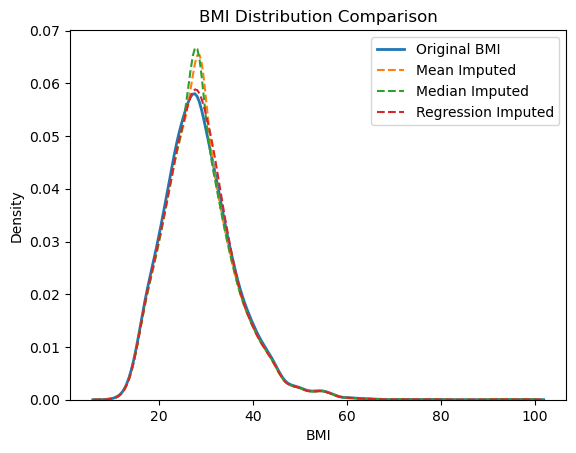

Original Correlation (Age vs BMI): 0.3333142180677445
Original Correlation (Glucose vs BMI): 0.17567173570874337
Mean Correlation (Age vs BMI): 0.32586051660363313
Mean Correlation (Glucose vs BMI): 0.16891292590809417
Median Correlation (Age vs BMI): 0.32421130167666923
Median Correlation (Glucose vs BMI): 0.1670331731710259
Regression Correlation (Age vs BMI): 0.3352364190036444
Regression Correlation (Glucose vs BMI): 0.1837960356848171

Mean Imputation - AUC: 0.7636, F1 Score: 0.0000

Median Imputation - AUC: 0.7834, F1 Score: 0.0000

Regression Imputation - AUC: 0.7729, F1 Score: 0.0000
Mean MSE on masked BMI: 67.3356
Median MSE on masked BMI: 68.4395
Regression MSE on masked BMI: 50.1751


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, mean_squared_error

# -------------------------------------------
# Step 1: Load Dataset
# -------------------------------------------
df = stroke.copy()
df_original = df[df['bmi'].notna()]

# -------------------------------------------
# Step 2: Create Data Copies for Imputation
# -------------------------------------------
df_mean = df.copy()
df_median = df.copy()
df_reg = df.copy()

# -------------------------------------------
# Step 3: Mean and Median Imputation
# -------------------------------------------
mean_bmi = df_mean['bmi'].mean()
median_bmi = df_median['bmi'].median()

df_mean['bmi'].fillna(mean_bmi, inplace=True)
df_median['bmi'].fillna(median_bmi, inplace=True)

# -------------------------------------------
# Step 4: Regression-Based Imputation
# -------------------------------------------
# Use rows where BMI is known
df_train = df_reg[df_reg['bmi'].notna()]
df_test = df_reg[df_reg['bmi'].isna()]

# Predictors: Age and Glucose
X_train = df_train[['age', 'avg_glucose_level']]
y_train = df_train['bmi']
X_test = df_test[['age', 'avg_glucose_level']]

# Polynomial regression (degree=2)
poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_model.fit(X_train, y_train)
bmi_pred = poly_model.predict(X_test)

# Fill in the missing values
df_reg.loc[df_reg['bmi'].isna(), 'bmi'] = bmi_pred

# -------------------------------------------
# Step 5: Plot Distributions of Imputed Values
# -------------------------------------------
sns.kdeplot(df_original['bmi'], label='Original BMI', lw=2)
sns.kdeplot(df_mean['bmi'], label='Mean Imputed', linestyle='--')
sns.kdeplot(df_median['bmi'], label='Median Imputed', linestyle='--')
sns.kdeplot(df_reg['bmi'], label='Regression Imputed', linestyle='--')
plt.legend()
plt.title('BMI Distribution Comparison')
plt.xlabel('BMI')
plt.ylabel('Density')
plt.show()

# -------------------------------------------
# Step 6: Correlation Check
# -------------------------------------------
def print_correlations(df, label):
    print(f"{label} Correlation (Age vs BMI):", df['age'].corr(df['bmi']))
    print(f"{label} Correlation (Glucose vs BMI):", df['avg_glucose_level'].corr(df['bmi']))

print_correlations(df_original, "Original")
print_correlations(df_mean, "Mean")
print_correlations(df_median, "Median")
print_correlations(df_reg, "Regression")

# -------------------------------------------
# Step 7: Predictive Model Performance
# -------------------------------------------
def evaluate_model(df, name):
    # Simple preprocessing
    df_model = df.dropna(subset=['bmi'])
    X = df_model[['age', 'avg_glucose_level', 'bmi']]
    y = df_model['stroke']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, y_proba)
    f1 = f1_score(y_test, y_pred)
    
    print(f"\n{name} - AUC: {auc:.4f}, F1 Score: {f1:.4f}")

evaluate_model(df_mean, "Mean Imputation")
evaluate_model(df_median, "Median Imputation")
evaluate_model(df_reg, "Regression Imputation")

# -------------------------------------------
# Step 8: MSE Evaluation by Masking Known Values (Optional)
# -------------------------------------------
def evaluate_mse_with_masking(df, method_name, method_func):
    # Mask 10% of known BMI values
    bmi_known = df[df['bmi'].notna()].copy()
    mask_indices = bmi_known.sample(frac=0.1, random_state=42).index
    true_values = bmi_known.loc[mask_indices, 'bmi'].copy()
    
    # Create a temporary dataset with BMI values masked
    df_temp = df.copy()
    df_temp.loc[mask_indices, 'bmi'] = np.nan
    df_temp = method_func(df_temp)  # Impute
    
    imputed_values = df_temp.loc[mask_indices, 'bmi']
    mse = mean_squared_error(true_values, imputed_values)
    print(f"{method_name} MSE on masked BMI:", round(mse, 4))

# Define imputation functions
def impute_mean(df):
    df['bmi'] = df['bmi'].fillna(df['bmi'].mean())
    return df

def impute_median(df):
    df['bmi'] = df['bmi'].fillna(df['bmi'].median())
    return df

def impute_regression(df):
    train = df[df['bmi'].notna()]
    test = df[df['bmi'].isna()]
    X_train = train[['age', 'avg_glucose_level']]
    y_train = train['bmi']
    X_test = test[['age', 'avg_glucose_level']]
    model = make_pipeline(PolynomialFeatures(2), LinearRegression())
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    df.loc[df['bmi'].isna(), 'bmi'] = preds
    return df

# Run MSE evaluation
evaluate_mse_with_masking(df.copy(), "Mean", impute_mean)
evaluate_mse_with_masking(df.copy(), "Median", impute_median)
evaluate_mse_with_masking(df.copy(), "Regression", impute_regression)

Calculate a risk score for each row using the categories in the data.

               high_risk_category stroke_rate_high_risk stroke_rate_others  \
hypertension                  1.0               0.13253           0.039688   
heart_disease                 1.0               0.17029           0.041796   
ever_married                  Yes              0.065613           0.016515   
gender                       Male              0.051064           0.047094   
work_type           Self-employed              0.079365            0.04289   
smoking_status    formerly smoked              0.079186           0.042367   
Residence_type              Urban              0.052003           0.045364   

               risk_increase    weight  
hypertension        0.092842  0.722544  
heart_disease       0.128494       1.0  
ever_married        0.049098  0.382104  
gender               0.00397  0.030894  
work_type           0.036475  0.283863  
smoking_status      0.036819   0.28654  
Residence_type      0.006639  0.051668  
   risk_score  stroke
0    1.751206       1
1  

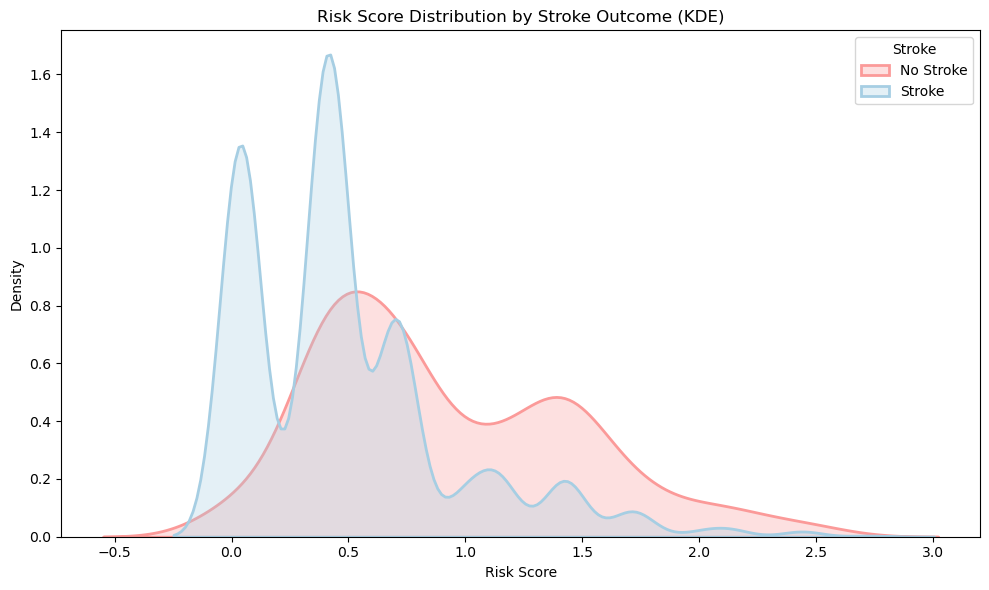

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df=stroke.copy()


# List categorical features to check
categorical_features = ['hypertension', 'heart_disease', 'ever_married', 'gender',
                        'work_type', 'smoking_status', 'Residence_type']

# Step 1-3: Find high-risk category and risk increase per feature
risk_info = {}
for feature in categorical_features:
    # Calculate stroke rate per category
    rates = df.groupby(feature)['stroke'].mean()
    # Find category with highest stroke rate
    high_risk_cat = rates.idxmax()
    high_risk_rate = rates.max()
    other_rate = df.loc[df[feature] != high_risk_cat, 'stroke'].mean()
    lift = high_risk_rate - other_rate
    
    risk_info[feature] = {
        'high_risk_category': high_risk_cat,
        'stroke_rate_high_risk': high_risk_rate,
        'stroke_rate_others': other_rate,
        'risk_increase': lift
    }

# Filter features with positive risk increase
risk_info = {k:v for k,v in risk_info.items() if v['risk_increase'] > 0}

# Step 4: Normalize risk increases to weights (0 to 1)
max_lift = max(v['risk_increase'] for v in risk_info.values())
for k in risk_info:
    risk_info[k]['weight'] = risk_info[k]['risk_increase'] / max_lift

# Step 5: Define function to compute risk score for each row
def compute_automated_risk_score(row):
    score = 0
    for feature, info in risk_info.items():
        if row[feature] == info['high_risk_category']:
            score += info['weight']
    return score

# Step 6: Apply risk score to dataframe and rename column
df['risk_score'] = df.apply(compute_automated_risk_score, axis=1)

# Optional: Show risk info
risk_df = pd.DataFrame(risk_info).T[['high_risk_category', 'stroke_rate_high_risk', 'stroke_rate_others', 'risk_increase', 'weight']]
print(risk_df)

print(df[['risk_score', 'stroke']].head(10))


plt.figure(figsize=(10, 6))

sns.kdeplot(data=df, x='risk_score', hue='stroke',
            palette=['#A6CEE3', '#FB9A99'],  # light blue and light red/pink
            common_norm=False,
            fill=True,           # fill under curve with color
            alpha=0.3,           # transparency for light color
            linewidth=2)

plt.title('Risk Score Distribution by Stroke Outcome (KDE)')
plt.xlabel('Risk Score')
plt.ylabel('Density')
plt.legend(title='Stroke', labels=['No Stroke', 'Stroke'])
plt.tight_layout()
plt.show()

Start with the dataframe and impute the BMI with the function created and add the risk score column.

In [6]:
df = stroke.copy()  # Make sure to call .copy() with parentheses

cleaned_df = impute_regression(df)

cleaned_df['risk_score'] = cleaned_df.apply(compute_automated_risk_score, axis=1)


print(cleaned_df)

      gender   age  hypertension  heart_disease ever_married      work_type  \
0       Male  67.0             0              1          Yes        Private   
1     Female  61.0             0              0          Yes  Self-employed   
2       Male  80.0             0              1          Yes        Private   
3     Female  49.0             0              0          Yes        Private   
4     Female  79.0             1              0          Yes  Self-employed   
...      ...   ...           ...            ...          ...            ...   
5105  Female  80.0             1              0          Yes        Private   
5106  Female  81.0             0              0          Yes  Self-employed   
5107  Female  35.0             0              0          Yes  Self-employed   
5108    Male  51.0             0              0          Yes        Private   
5109  Female  44.0             0              0          Yes       Govt_job   

     Residence_type  avg_glucose_level        bmi  

Try clustering the data to find segments that are more prone to stroke.

Evaluating silhouette scores for k=2 to 10:
k=2, silhouette score=0.2178
k=3, silhouette score=0.2254
k=4, silhouette score=0.2115
k=5, silhouette score=0.1914
k=6, silhouette score=0.1732
k=7, silhouette score=0.1649
k=8, silhouette score=0.1697
k=9, silhouette score=0.1653
k=10, silhouette score=0.1589

Best k by silhouette score: 3 (score=0.2254)

Cluster summary:
         stroke_rate  avg_risk_score        age  avg_glucose_level        bmi  \
cluster                                                                         
0           0.050877        0.634620  52.733585          89.822668  30.512055   
1           0.144543        0.966290  62.469027         203.127507  33.809050   
2           0.001971        0.066374  16.495401          94.123988  23.742302   

         hypertension  heart_disease     risk_label  
cluster                                              
0            0.100722       0.049158  Elevated Risk  
1            0.300885       0.194690      High Risk  
2       

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


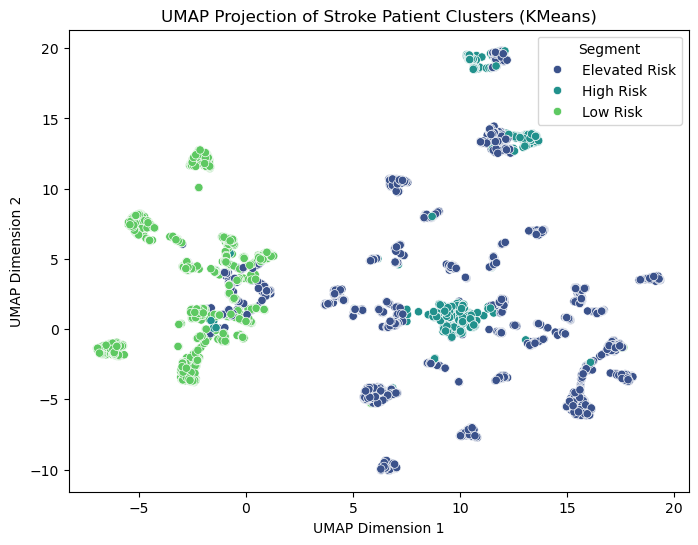

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Load data
df = cleaned_df



# Prepare features for clustering
num_features = ['age', 'avg_glucose_level', 'bmi', 'risk_score']
cat_features = ['gender', 'ever_married', 'work_type', 'Residence_type',
                'hypertension', 'heart_disease', 'smoking_status']

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

X_processed = preprocessor.fit_transform(df)

# Find optimal k using silhouette score
best_k = None
best_score = -1
print("Evaluating silhouette scores for k=2 to 10:")
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_processed)
    score = silhouette_score(X_processed, labels)
    print(f"k={k}, silhouette score={score:.4f}")
    if score > best_score:
        best_score = score
        best_k = k

print(f"\nBest k by silhouette score: {best_k} (score={best_score:.4f})")

# Fit final KMeans with best k
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df['cluster'] = kmeans_final.fit_predict(X_processed)

# Label clusters by stroke rate
cluster_stats = df.groupby('cluster').agg({
    'stroke': 'mean',
    'risk_score': 'mean',
    'age': 'mean',
    'avg_glucose_level': 'mean',
    'bmi': 'mean',
    'hypertension': 'mean',
    'heart_disease': 'mean'
}).rename(columns={'stroke': 'stroke_rate', 'risk_score': 'avg_risk_score'})

def label_cluster(row):
    if row.stroke_rate < 0.02:
        return 'Low Risk'
    elif row.stroke_rate < 0.05:
        return 'Moderate Risk'
    elif row.stroke_rate < 0.10:
        return 'Elevated Risk'
    else:
        return 'High Risk'

cluster_stats['risk_label'] = cluster_stats.apply(label_cluster, axis=1)

label_map = cluster_stats['risk_label'].to_dict()
df['segment'] = df['cluster'].map(label_map).astype('category')


print("\nCluster summary:")
print(cluster_stats)

# Visualize clusters with UMAP
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X_processed)

plt.figure(figsize=(8,6))
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=df['segment'], palette='viridis')
plt.title('UMAP Projection of Stroke Patient Clusters (KMeans)')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend(title='Segment')
plt.show()

Drop cluster from dataframe 

In [17]:
if 'cluster' in cleaned_df.columns:
    cleaned_df.drop(columns=['cluster'], inplace=True)

Loop through machine learning models 

In [21]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report

# Import classifiers
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier,
    ExtraTreesClassifier, HistGradientBoostingClassifier
)
from sklearn.linear_model import (
    LogisticRegression, RidgeClassifier, SGDClassifier, PassiveAggressiveClassifier, Perceptron
)
from sklearn.naive_bayes import (
    GaussianNB, BernoulliNB, ComplementNB, MultinomialNB, CategoricalNB
)
from sklearn.neighbors import (
    KNeighborsClassifier, RadiusNeighborsClassifier, NearestCentroid
)
from sklearn.svm import (
    SVC, LinearSVC, NuSVC
)
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
)
from sklearn.calibration import CalibratedClassifierCV
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.dummy import DummyClassifier
from sklearn.multiclass import OneVsRestClassifier



df = cleaned_df.copy()


# Define features and target
target = 'stroke'
features = [
    'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
    'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
    'smoking_status', 'risk_score', 'segment'
]

X = df[features]
y = df[target]


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42, test_size=0.2
)

# Preprocessing pipeline
# Updated feature split:
numeric_features = ['age', 'avg_glucose_level', 'bmi', 'risk_score']  # Only truly numeric features here

categorical_features = [
    'gender', 'ever_married', 'work_type', 'Residence_type', 
    'smoking_status', 'segment', 'hypertension', 'heart_disease'
]
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define classifiers
classifiers = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Bagging": BaggingClassifier(random_state=42),
    "ExtraTrees": ExtraTreesClassifier(random_state=42),
    "HistGradientBoosting": HistGradientBoostingClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "RidgeClassifier": RidgeClassifier(random_state=42),
    "SGDClassifier": SGDClassifier(max_iter=1000, tol=1e-3, random_state=42),
    "PassiveAggressive": PassiveAggressiveClassifier(max_iter=1000, random_state=42),
    "Perceptron": Perceptron(max_iter=1000, random_state=42),
    "GaussianNB": GaussianNB(),
    "BernoulliNB": BernoulliNB(),
    "ComplementNB": ComplementNB(),
    "MultinomialNB": MultinomialNB(),
    "CategoricalNB": CategoricalNB(),
    "KNeighbors": KNeighborsClassifier(),
    "RadiusNeighbors": RadiusNeighborsClassifier(),
    "NearestCentroid": NearestCentroid(),
    "SVC": SVC(probability=True, random_state=42),
    "LinearSVC": LinearSVC(max_iter=10000, random_state=42),
    "NuSVC": NuSVC(probability=True, random_state=42),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "ExtraTree": ExtraTreeClassifier(random_state=42),
    "LinearDiscriminantAnalysis": LinearDiscriminantAnalysis(),
    "QuadraticDiscriminantAnalysis": QuadraticDiscriminantAnalysis(),
    "CalibratedClassifier": CalibratedClassifierCV(estimator=LogisticRegression(), cv=3),
    "LabelPropagation": LabelPropagation(),
    "LabelSpreading": LabelSpreading(),
    "DummyClassifier": DummyClassifier(strategy='most_frequent'),
    "OneVsRest_LogisticRegression": OneVsRestClassifier(LogisticRegression(max_iter=1000)),
    "OneVsRest_SVC": OneVsRestClassifier(SVC(probability=True)),
}

print(f"Running {len(classifiers)} classifiers...\n")

for name, clf in classifiers.items():
    try:
        pipeline = ImbPipeline([
            ('preprocessor', preprocessor),
            ('smote', SMOTE(random_state=42)),
            ('classifier', clf)
        ])

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        print(f"--- Classifier: {name} ---")
        print(classification_report(y_test, y_pred, target_names=['No Stroke', 'Stroke']))
        print("\n" + "="*60 + "\n")

    except Exception as e:
        print(f"Failed to train {name}: {e}\n")

Running 32 classifiers...

--- Classifier: RandomForest ---
              precision    recall  f1-score   support

   No Stroke       0.96      0.97      0.96       972
      Stroke       0.19      0.14      0.16        50

    accuracy                           0.93      1022
   macro avg       0.58      0.56      0.56      1022
weighted avg       0.92      0.93      0.92      1022



--- Classifier: GradientBoosting ---
              precision    recall  f1-score   support

   No Stroke       0.96      0.92      0.94       972
      Stroke       0.17      0.32      0.23        50

    accuracy                           0.89      1022
   macro avg       0.57      0.62      0.58      1022
weighted avg       0.92      0.89      0.91      1022



--- Classifier: AdaBoost ---
              precision    recall  f1-score   support

   No Stroke       0.98      0.75      0.85       972
      Stroke       0.13      0.72      0.22        50

    accuracy                           0.75      102

Build an ensemble model to leverage the best models from the loop

In [22]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Assuming you have your cleaned dataframe 'cleaned_df' with target 'stroke'
df = cleaned_df.copy()

# Define features and target
X = df.drop(columns=['stroke'])
y = df['stroke']

# Define numeric and categorical features
numeric_features = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'risk_score']
categorical_features = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'segment']

# Preprocessing pipelines for numeric and categorical features
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Ensemble model with soft voting
ensemble = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)),
        ('rf', RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)),
        ('gb', GradientBoostingClassifier(n_estimators=200, random_state=42)),
        ('ada', AdaBoostClassifier(n_estimators=200, random_state=42))
    ],
    voting='soft'
)

# Full pipeline combining preprocessing and ensemble
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', ensemble)
])

# Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train ensemble model
pipeline.fit(X_train, y_train)

# Predict probabilities and classes
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
y_pred = pipeline.predict(X_test)

# Evaluation
print("=== Ensemble Model Performance ===")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Optional: threshold tuning for better recall (e.g., threshold=0.3)
threshold = 0.3
y_pred_thresh = (y_pred_proba >= threshold).astype(int)
print(f"\n=== Performance at threshold {threshold} ===")
print(classification_report(y_test, y_pred_thresh))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_thresh))

=== Ensemble Model Performance ===
ROC AUC: 0.8373

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       972
           1       0.50      0.14      0.22        50

    accuracy                           0.95      1022
   macro avg       0.73      0.57      0.60      1022
weighted avg       0.93      0.95      0.94      1022

Confusion Matrix:
[[965   7]
 [ 43   7]]

=== Performance at threshold 0.3 ===
              precision    recall  f1-score   support

           0       0.99      0.81      0.89       972
           1       0.17      0.78      0.28        50

    accuracy                           0.81      1022
   macro avg       0.58      0.79      0.58      1022
weighted avg       0.95      0.81      0.86      1022

Confusion Matrix:
[[784 188]
 [ 11  39]]


Build a neural network to try to get a better prediction.

In [23]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Copy cleaned df
df = cleaned_df.copy()

# Define features and target
target = 'stroke'
features = [
    'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
    'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
    'smoking_status', 'risk_score', 'segment'
]

X = df[features]
y = df[target]

# Split dataset with stratification
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# Separate numeric and categorical features
numeric_features = ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'risk_score']
categorical_features = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'segment']

# Preprocessing pipelines
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Fit and transform train and test
X_train = preprocessor.fit_transform(X_train_raw)
X_test = preprocessor.transform(X_test_raw)

# Compute class weights to handle imbalance
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

# Build the neural network model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu'),
    Dropout(0.2),

    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-5)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    class_weight=class_weights_dict,
    callbacks=[early_stopping, reduce_lr],
    verbose=2
)

# Predict probabilities on test set
y_pred_prob = model.predict(X_test).flatten()

# Find best threshold based on F1 score
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_prob)
f1_scores = 2 * precisions * recalls / (precisions + recalls + 1e-10)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Best threshold for max F1: {best_threshold:.3f}")

# Predict classes using best threshold
y_pred = (y_pred_prob >= best_threshold).astype(int)

# Evaluation metrics
print(classification_report(y_test, y_pred, target_names=['No Stroke', 'Stroke']))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_prob):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Epoch 1/100
103/103 - 3s - 29ms/step - accuracy: 0.6947 - auc: 0.7162 - loss: 0.6630 - val_accuracy: 0.5257 - val_auc: 0.8049 - val_loss: 0.7011 - learning_rate: 1.0000e-03
Epoch 2/100
103/103 - 0s - 2ms/step - accuracy: 0.6861 - auc: 0.7839 - loss: 0.5640 - val_accuracy: 0.6296 - val_auc: 0.8143 - val_loss: 0.5880 - learning_rate: 1.0000e-03
Epoch 3/100
103/103 - 0s - 3ms/step - accuracy: 0.6984 - auc: 0.8008 - loss: 0.5183 - val_accuracy: 0.6504 - val_auc: 0.8120 - val_loss: 0.5594 - learning_rate: 1.0000e-03
Epoch 4/100
103/103 - 0s - 2ms/step - accuracy: 0.6901 - auc: 0.8194 - loss: 0.5129 - val_accuracy: 0.6785 - val_auc: 0.8148 - val_loss: 0.5058 - learning_rate: 1.0000e-03
Epoch 5/100
103/103 - 0s - 2ms/step - accuracy: 0.7128 - auc: 0.8228 - loss: 0.4948 - val_accuracy: 0.6834 - val_auc: 0.8128 - val_loss: 0.4986 - learning_rate: 1.0000e-03
Epoch 6/100
103/103 - 0s - 2ms/step - accuracy: 0.6901 - auc: 0.8338 - loss: 0.4751 - val_accuracy: 0.7090 - val_auc: 0.8076 - val_loss: 0.

Use a grid search to get combinations of features that best predict stroke

In [25]:
import itertools
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils import class_weight
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ======== SETUP ========

# Replace this with your actual cleaned data
df = cleaned_df.copy()

# Features and target
all_features = [
    'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
    'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
    'smoking_status', 'risk_score', 'segment'
]
target = 'stroke'

# Split data once
X_full = df[all_features]
y_full = df[target]
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, stratify=y_full, random_state=42
)

# ======== UTILITY FUNCTIONS ========

def get_preprocessor(numeric_features, categorical_features):
    numeric_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')
    return ColumnTransformer([
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

def build_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def evaluate_subset(features_subset):
    X_train_sub = X_train_raw[list(features_subset)].copy()
    X_test_sub = X_test_raw[list(features_subset)].copy()

    numeric = X_train_sub.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical = X_train_sub.select_dtypes(include=['object', 'category']).columns.tolist()

    preprocessor = get_preprocessor(numeric, categorical)
    X_train = preprocessor.fit_transform(X_train_sub)
    X_test = preprocessor.transform(X_test_sub)

    cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    cw_dict = {0: cw[0], 1: cw[1]}

    model = build_model(X_train.shape[1])
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5)
    ]

    model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=50,
        batch_size=32,
        verbose=0,
        class_weight=cw_dict,
        callbacks=callbacks
    )

    y_prob = model.predict(X_test).flatten()
    precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
    f1_scores = 2 * precision * recall / (precision + recall + 1e-10)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]

    y_pred = (y_prob >= best_threshold).astype(int)
    f1 = f1_scores[best_idx]
    auc = roc_auc_score(y_test, y_prob)

    print("=" * 60)
    print(f"Features: {features_subset}")
    print(f"Best F1: {f1:.4f}, AUC: {auc:.4f}, Threshold: {best_threshold:.3f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=["No Stroke", "Stroke"]))

    return {
        'features': features_subset,
        'f1': f1,
        'auc': auc
    }

# ======== RUN RANDOMIZED SUBSET GRID SEARCH ========

results = []

# Sample 100 random subsets of size 3 to 12
sampled_subsets = random.sample(
    list(itertools.chain.from_iterable(
        itertools.combinations(all_features, r) for r in range(3, len(all_features)+1)
    )),
    100  # You can increase this number to be more exhaustive
)

for subset in sampled_subsets:
    result = evaluate_subset(subset)
    results.append(result)

# Sort and display top 10 results
results_df = pd.DataFrame(results)
top_results = results_df.sort_values(by='f1', ascending=False).head(10)

print("\n🔝 Top 10 Feature Subsets by F1:")
print(top_results)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Features: ('gender', 'age', 'hypertension', 'ever_married', 'work_type')
Best F1: 0.3195, AUC: 0.8272, Threshold: 0.570
Classification Report:
              precision    recall  f1-score   support

   No Stroke       0.97      0.91      0.94       972
      Stroke       0.23      0.54      0.32        50

    accuracy                           0.89      1022
   macro avg       0.60      0.72      0.63      1022
weighted avg       0.94      0.89      0.91      1022

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Features: ('gender', 'hypertension', 'work_type', 'Residence_type', 'avg_glucose_level', 'segment')
Best F1: 0.2041, AUC: 0.7226, Threshold: 0.539
Classification Report:
              precision    recall  f1-score   support

   No Stroke       0.97      0.83      0.89       972
      Stroke       0.13      0.50      0.20        50

    accuracy                           0.81      1022
   macro avg       0.55      0.66      0.55      1022
weighted a


Train the neural network again using the top features

In [27]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils import class_weight
from sklearn.metrics import precision_recall_curve, classification_report, roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ======== SETUP ========

df = cleaned_df.copy()  # Your cleaned DataFrame

features_subset = ['age', 'hypertension', 'Residence_type', 'bmi', 'segment']
target = 'stroke'

# Convert categorical to category dtype for correct encoding
for col in ['Residence_type', 'segment']:
    df[col] = df[col].astype('category')

X = df[features_subset]
y = df[target]

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ======== PREPROCESSING ========

numeric_features = X_train_raw.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train_raw.select_dtypes(include=['category', 'object']).columns.tolist()

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
])

X_train = preprocessor.fit_transform(X_train_raw)
X_test = preprocessor.transform(X_test_raw)

# ======== MODEL BUILDING ========

def build_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.4),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
cw_dict = {0: cw[0], 1: cw[1]}

model = build_model(X_train.shape[1])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5)
]

# ======== TRAINING ========

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    class_weight=cw_dict,
    callbacks=callbacks,
    verbose=1
)

# ======== EVALUATION ========

y_prob = model.predict(X_test).flatten()
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
f1_scores = 2 * precision * recall / (precision + recall + 1e-10)
best_idx = np.argmax(f1_scores[:-1])  # last threshold has no corresponding f1
best_threshold = thresholds[best_idx]

y_pred = (y_prob >= best_threshold).astype(int)

f1 = f1_scores[best_idx]
auc = roc_auc_score(y_test, y_prob)

print(f"\nResults using features: {features_subset}")
print(f"Best threshold for F1: {best_threshold:.3f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC Score: {auc:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["No Stroke", "Stroke"]))

Epoch 1/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6548 - loss: 0.6207 - val_accuracy: 0.6895 - val_loss: 0.6150 - learning_rate: 0.0010
Epoch 2/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6844 - loss: 0.4966 - val_accuracy: 0.6601 - val_loss: 0.5894 - learning_rate: 0.0010
Epoch 3/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6843 - loss: 0.4574 - val_accuracy: 0.7200 - val_loss: 0.4871 - learning_rate: 0.0010
Epoch 4/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7087 - loss: 0.4620 - val_accuracy: 0.7103 - val_loss: 0.4576 - learning_rate: 0.0010
Epoch 5/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6720 - loss: 0.5141 - val_accuracy: 0.6980 - val_loss: 0.4330 - learning_rate: 0.0010
Epoch 6/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6914 - loss: 0.4356 - val_accuracy: 0.7054 - val_loss: 0.4337 - learning_rate: 0.0010
Epoch 7/50
103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6826 - loss: 0.4593 - 